In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_recall_curve, auc, roc_curve, roc_auc_score
)
from sklearn.preprocessing import StandardScaler
from joblib import dump
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# loading dataset to pandas dataframe
credit_card_data = pd.read_csv('creditcard_id.csv')

In [3]:
print(credit_card_data.head())

    id        V1        V2        V3        V4        V5        V6        V7  \
0  0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2  1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3  1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4  2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amoun

In [4]:
print(credit_card_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
print(credit_card_data.isnull().sum())

id        0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [6]:
print(credit_card_data['Class'].value_counts())

Class
0    284315
1       492
Name: count, dtype: int64


In [7]:
# separating the data for analysis
legit = credit_card_data[credit_card_data.Class == 0]
fraud = credit_card_data[credit_card_data.Class == 1]

In [8]:
print("Legit transactions shape:", legit.shape)
print("Fraudulent transactions shape:", fraud.shape)

Legit transactions shape: (284315, 31)
Fraudulent transactions shape: (492, 31)


In [9]:
# Under-Sampling: Build a sample dataset containing similar distribution
legit_sample = legit.sample(n=len(fraud))

In [10]:
# Concatenating two DataFrames
new_dataset = pd.concat([legit_sample, fraud], axis=0).sample(frac=1, random_state=42)

In [11]:
print(new_dataset.head())

              id         V1        V2         V3        V4        V5  \
42756    41233.0 -10.645800  5.918307 -11.671043  8.807369 -7.975501   
200600  133499.0  -0.560954  0.152648   0.959511 -1.407596  0.316016   
111690   72327.0  -4.198735  0.194121  -3.917586  3.920748 -1.875486   
237164  149124.0  -0.164872  0.475360   0.882445  0.010332  1.047355   
239240  150016.0   1.955162 -0.411396  -1.664663  0.186003  1.946557   

              V6         V7        V8        V9  ...       V21       V22  \
42756  -3.586806 -13.616797  6.428169 -7.368451  ...  2.571970  0.206809   
200600  0.578174   0.292231  0.168738 -1.053709  ...  0.101941  0.803009   
111690 -2.118933  -3.614445  1.687884 -2.189871  ...  0.801312 -0.183001   
237164 -0.878816   1.161492 -0.715230 -0.108977  ... -0.259771 -0.307662   
239240  3.969139  -1.128276  1.050656  0.742596  ...  0.219928  0.687659   

             V23       V24       V25       V26       V27       V28  Amount  \
42756  -1.667801  0.558419 -0.02

In [12]:
print(new_dataset['Class'].value_counts())

Class
1    492
0    492
Name: count, dtype: int64


In [13]:
# Splitting the data into Features & Targets
X = new_dataset.drop(columns='Class', axis=1)
Y = new_dataset['Class']

In [14]:
# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)
feature_names = credit_card_data.columns[:-1]

In [15]:
# Split the data into Training data & Testing Data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=42)

In [16]:
print("Data shapes:", X.shape, X_train.shape, X_test.shape)
# print("Data shapes:", Y.shape, Y_train.shape, Y_test.shape)


Data shapes: (984, 30) (738, 30) (246, 30)


# Model Training: Gaussian Naive Bayes

In [17]:
model = GaussianNB(
    priors=None,  # You can set class priors if you know them
    var_smoothing=1e-9  # Add to variance for stability, default is fine in most cases
)

In [18]:
# Training the Naive Bayes Model with Training Data
model.fit(X_train, Y_train)

GaussianNB()

In [19]:
# Model Evaluation: Accuracy Score
# Predictions on training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)
print('Accuracy on Training data:', training_data_accuracy)

Accuracy on Training data: 0.9200542005420054


In [20]:
# Predictions on test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy on Test Data:', test_data_accuracy)

Accuracy on Test Data: 0.9105691056910569


In [21]:
# Cross-Validation Score
cv_scores = cross_val_score(model, X, Y, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Cross-Validation Scores: [0.91370558 0.92385787 0.9035533  0.91370558 0.93367347]
Mean CV Score: 0.9177 (+/- 0.0205)


In [22]:
# More detailed evaluation metrics
print("\nConfusion Matrix:")
cm = confusion_matrix(Y_test, X_test_prediction)
print(cm)


Confusion Matrix:
[[119   4]
 [ 18 105]]


Text(0.5, 36.72222222222221, 'Predicted Label')

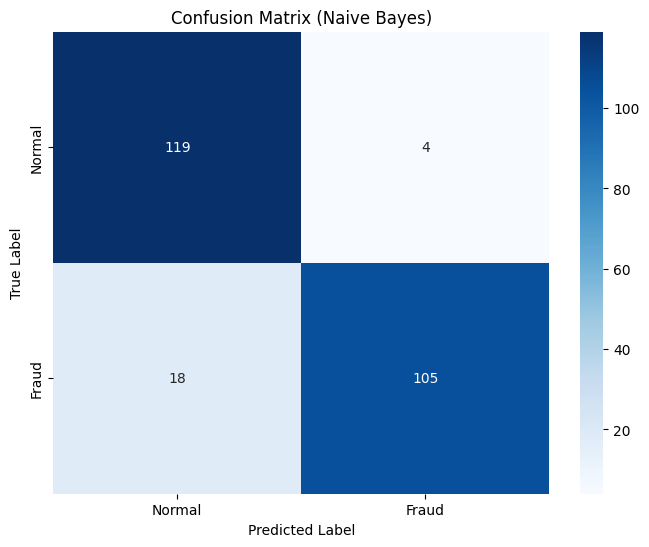

In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix (Naive Bayes)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

In [24]:
print("\nClassification Report:")
print(classification_report(Y_test, X_test_prediction))


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       123
           1       0.96      0.85      0.91       123

    accuracy                           0.91       246
   macro avg       0.92      0.91      0.91       246
weighted avg       0.92      0.91      0.91       246



In [25]:
# Save the model and scaler
model_filename = 'gaussian_naive_bayes_model.pkl'
scaler_filename = 'credit_card_fraud_scaler.pkl'

dump(model, model_filename)
dump(scaler, scaler_filename)

print(f"Naive Bayes model saved to: {model_filename}")
print(f"Scaler saved to: {scaler_filename}")

Naive Bayes model saved to: gaussian_naive_bayes_model.pkl
Scaler saved to: credit_card_fraud_scaler.pkl


# Model Training: Gradient Boosting

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

In [27]:
# Model Training: Gradient Boosting
model = GradientBoostingClassifier(
    n_estimators=100,  # number of trees
    learning_rate=0.1,
    max_depth=4,
    min_samples_split=5,
    min_samples_leaf=2,
    subsample=0.8,
    max_features=0.8,
    random_state=42
)

In [28]:
# Training the Gradient Boosting Model with Training Data
model.fit(X_train, Y_train)

GradientBoostingClassifier(max_depth=4, max_features=0.8, min_samples_leaf=2,
                           min_samples_split=5, random_state=42, subsample=0.8)

In [29]:
# Model Evaluation: Accuracy Score
# Predictions on training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)
print('Accuracy on Training data:', training_data_accuracy)

Accuracy on Training data: 1.0


In [30]:
# Predictions on test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy on Test Data:', test_data_accuracy)

Accuracy on Test Data: 0.9186991869918699


In [31]:
# More detailed evaluation metrics
print("\nConfusion Matrix:")
print(confusion_matrix(Y_test, X_test_prediction))


Confusion Matrix:
[[116   7]
 [ 13 110]]


Text(0.5, 36.72222222222221, 'Predicted Label')

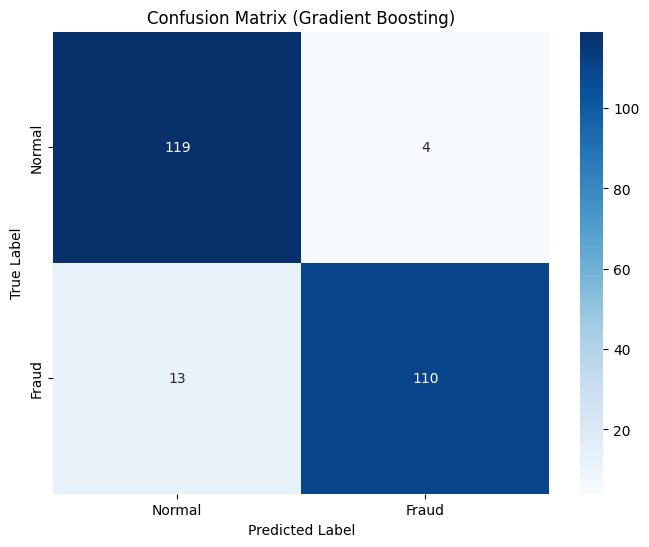

In [67]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix (Gradient Boosting)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

In [33]:
# Cross-Validation Score
cv_scores = cross_val_score(model, X, Y, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Cross-Validation Scores: [0.92893401 0.93908629 0.91878173 0.93401015 0.94387755]
Mean CV Score: 0.9329 (+/- 0.0173)


In [34]:
print("\nClassification Report:")
print(classification_report(Y_test, X_test_prediction))


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       123
           1       0.94      0.89      0.92       123

    accuracy                           0.92       246
   macro avg       0.92      0.92      0.92       246
weighted avg       0.92      0.92      0.92       246



In [35]:
# Save the model and scaler
model_filename = 'gradient_boosting_model.pkl'
scaler_filename = 'credit_card_fraud_scaler.pkl'

dump(model, model_filename)
dump(scaler, scaler_filename)

['credit_card_fraud_scaler.pkl']

# Model Training: KNN

In [36]:
from sklearn.neighbors import KNeighborsClassifier

In [37]:
k = 5  # You can tune this hyperparameter
model = KNeighborsClassifier(n_neighbors=k)

In [38]:
# Training the KNN Model with Training Data
model.fit(X_train, Y_train)

KNeighborsClassifier()

In [39]:
# Model Evaluation: Accuracy Score
# Predictions on training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)
print('Accuracy on Training data:', training_data_accuracy)

Accuracy on Training data: 0.9390243902439024


In [40]:
# Predictions on test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy on Test Data:', test_data_accuracy)

Accuracy on Test Data: 0.9065040650406504


In [41]:
# More detailed evaluation metrics
print("\nConfusion Matrix:")
print(confusion_matrix(Y_test, X_test_prediction))


Confusion Matrix:
[[119   4]
 [ 19 104]]


Text(0.5, 36.72222222222221, 'Predicted Label')

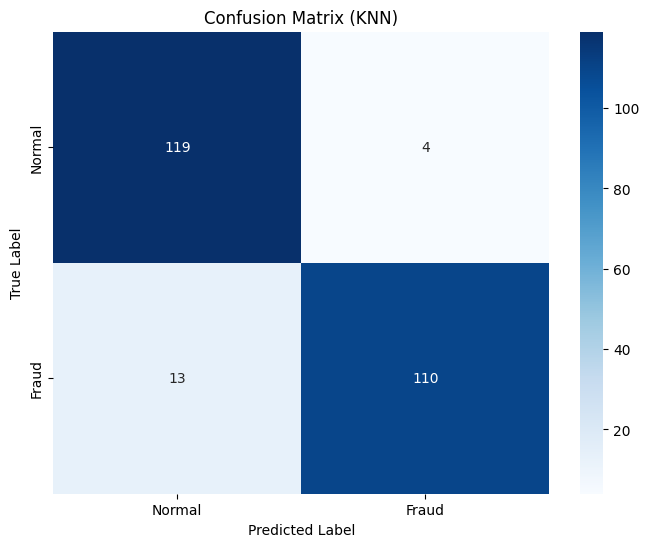

In [68]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix (KNN)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

In [43]:
# Cross-Validation Score
cv_scores = cross_val_score(model, X, Y, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Cross-Validation Scores: [0.92893401 0.92385787 0.92385787 0.88324873 0.93877551]
Mean CV Score: 0.9197 (+/- 0.0381)


In [44]:
print("\nClassification Report:")
print(classification_report(Y_test, X_test_prediction))


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       123
           1       0.96      0.85      0.90       123

    accuracy                           0.91       246
   macro avg       0.91      0.91      0.91       246
weighted avg       0.91      0.91      0.91       246



In [45]:
# Save the model and scaler
model_filename = 'knn_model.pkl'
scaler_filename = 'credit_card_fraud_scaler.pkl'

dump(model, model_filename)
dump(scaler, scaler_filename)

['credit_card_fraud_scaler.pkl']

# Model Training: Random Forest

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
model = RandomForestClassifier(
    n_estimators=100,  # number of trees
    max_depth=None,   # nodes are expanded until all leaves are pure or contain less than min_samples_split samples
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',  # number of features to consider when looking for the best split
    bootstrap=True,   # use bootstrapping
    class_weight='balanced',  # adjust weights inversely proportional to class frequencies
    random_state=42
)

In [48]:
# Training the Random Forest Model with Training Data
model.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [49]:
# Model Evaluation: Accuracy Score
# Predictions on training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)
print('Accuracy on Training data:', training_data_accuracy)

Accuracy on Training data: 1.0


In [50]:
# Predictions on test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy on Test Data:', test_data_accuracy)

Accuracy on Test Data: 0.9227642276422764


In [51]:
# Cross-Validation Score
cv_scores = cross_val_score(model, X, Y, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Cross-Validation Scores: [0.93908629 0.94416244 0.92893401 0.94416244 0.94897959]
Mean CV Score: 0.9411 (+/- 0.0137)


In [52]:
# More detailed evaluation metrics
print("\nConfusion Matrix:")
cm = confusion_matrix(Y_test, X_test_prediction)
print(cm)


Confusion Matrix:
[[118   5]
 [ 14 109]]


Text(0.5, 36.72222222222221, 'Predicted Label')

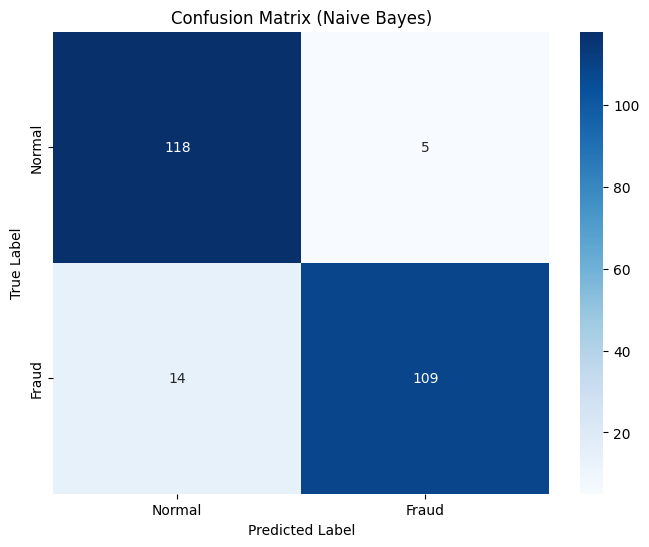

In [53]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix (Random Forest)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

In [54]:
print("\nClassification Report:")
print(classification_report(Y_test, X_test_prediction))


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.93       123
           1       0.96      0.89      0.92       123

    accuracy                           0.92       246
   macro avg       0.93      0.92      0.92       246
weighted avg       0.93      0.92      0.92       246



In [55]:
# Save the model and scaler
model_filename = 'random_forest_model.pkl'
scaler_filename = 'credit_card_fraud_scaler.pkl'

dump(model, model_filename)
dump(scaler, scaler_filename)

['credit_card_fraud_scaler.pkl']

# Model Training: Logistic Regression

In [56]:
from sklearn.linear_model import LogisticRegression

In [57]:
model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)

In [58]:
# Training the Logistic Regression Model with Training Data
model.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

In [59]:
# Model Evaluation: Accuracy Score
# Predictions on training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)
print('Accuracy on Training data:', training_data_accuracy)

Accuracy on Training data: 0.9552845528455285


In [60]:
# Predictions on test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy on Test Data:', test_data_accuracy)

Accuracy on Test Data: 0.9308943089430894


In [61]:
# Cross-Validation Score
cv_scores = cross_val_score(model, X, Y, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Cross-Validation Scores: [0.93908629 0.94923858 0.93401015 0.93908629 0.96428571]
Mean CV Score: 0.9451 (+/- 0.0216)


In [62]:
# More detailed evaluation metrics
print("\nConfusion Matrix:")
cm = confusion_matrix(Y_test, X_test_prediction)
print(cm)


Confusion Matrix:
[[119   4]
 [ 13 110]]


Text(0.5, 36.72222222222221, 'Predicted Label')

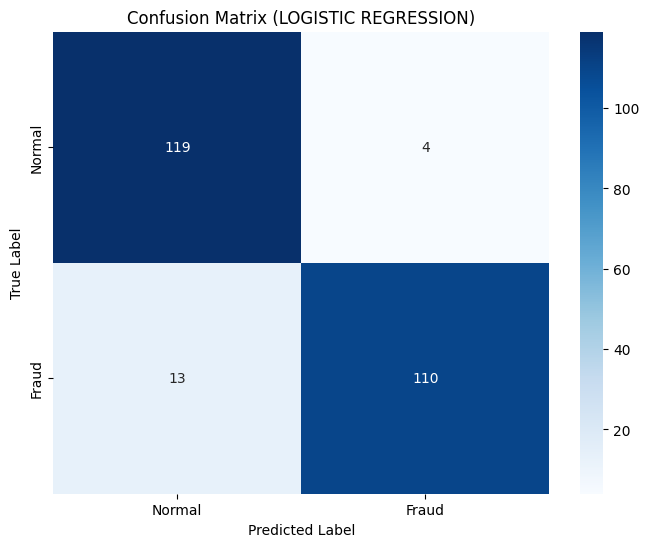

In [66]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix (LOGISTIC REGRESSION)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

In [64]:
print("\nClassification Report:")
print(classification_report(Y_test, X_test_prediction))


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       123
           1       0.96      0.89      0.93       123

    accuracy                           0.93       246
   macro avg       0.93      0.93      0.93       246
weighted avg       0.93      0.93      0.93       246



In [65]:
# Save the model and scaler
model_filename = 'lr_model.pkl'
scaler_filename = 'credit_card_fraud_scaler.pkl'

dump(model, model_filename)
dump(scaler, scaler_filename)

['credit_card_fraud_scaler.pkl']